# Akademikernes Akasse
Investiation of messages using topic modeling. Topic Modeling is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package. The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics.

The Steps
1. Preperation
2. Data Processing
3. Feature inspection
4. Feature creation

## 1) Preperation
- Modul imports
- Data imports
- Utility Functions

### Modul import

In [2]:
# common
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import pyodbc
from collections import Counter
from datetime import datetime

# visualization imports
from IPython.display import display
import seaborn as sns
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['image.cmap'] = 'gray'
import base64
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style

# languange processing imports
import nltk
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
# from googletrans import Translator
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from gensim.models import CoherenceModel
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# Remove unnecessary warnings
pd.options.mode.chained_assignment = None

C:\ProgramData\Anaconda3\envs\akademikernes_diagnostic\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [42]:
# Common
import pandas as pd
import numpy as np

# Visualization modules
import matplotlib.pyplot as plt

# Model modules
from sklearn.feature_extraction.text import TfidfVectorizer#, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from gensim.corpora import Dictionary
from gensim.corpora import MmCorpus
from gensim.test.utils import get_tmpfile
from gensim.models.ldamulticore import LdaMulticore

# Remove unnecessary warnings
pd.options.mode.chained_assignment = None

# other
from collections import Counter
import seaborn as sns

### Assist functions

In [3]:
def PlotValueCounts(df, column, topx=None):
    counts = df[column].value_counts()
    if topx:
        counts = counts[:topx,]
        title = 'Top {0} {1}'.format(topx, column)
    else:
        title = 'Rank of '.format(column)
    plt.figure(figsize=(10,8))
    sns.barplot(counts.values, counts.index, alpha=0.8)
    plt.title('{0}'.format(title))
    plt.ylabel(column)
    plt.xlabel('No of Occurences')
    plt.show()
    
def SummaryCounts(df):
    return df.value_counts()

### Data import
Import the data

In [4]:
server = "LIPHT-VM-01"#"LI-PH-01"
db = "Akademikernes_MSCRM"
con = pyodbc.connect('DRIVER={SQL Server};SERVER=' + server + ';DATABASE=' + db)

query="""
SELECT *
  FROM [Akademikernes_MSCRM].[_dataprep].[vw_LDA_Messages]
  """
df = pd.read_sql(query, con)
df.head()

,ThreadID,ThreadCreatedFromLetter,ThreadTotalMessageCount,ThreadStatus,ThreadSubject,ThreadResponsibleDepartment,ThreadResponsibleDepartmentTeam,ThreadHasInteraction,ThreadInitiatedBy,ThreadMessageRank,ThreadMessageIsFirstMemberMessage,ThreadMessageIsFirstAKAMessage,ThreadMessageID,ThreadMessageDirection,ThreadMessageDateCreated,ThreadMessageText
0,3F206D77-DFB5-E811-82B4-0050569118B0,0,1,Fuldført,Du er tilmeldt et arrangement,Jobmatch,Logistik,0,AKA,1,0,1,46206D77-DFB5-E811-82B4-0050569118B0,Udgående,2018-09-11 16:26:43,"\nDin booking er på plads\n \nVi bekræfter, at..."
1,A4B4F902-E4B5-E811-82B4-0050569118B0,0,1,Fuldført,Du er tilmeldt et arrangement,Jobmatch,Logistik,0,AKA,1,0,1,ABB4F902-E4B5-E811-82B4-0050569118B0,Udgående,2018-09-11 16:59:21,"\n \nDin booking er på plads\nVi bekræfter, at..."
2,C7AAAE22-E4B5-E811-82B4-0050569118B0,0,1,Fuldført,Du er tilmeldt et arrangement,Jobmatch,Logistik,0,AKA,1,0,1,CEAAAE22-E4B5-E811-82B4-0050569118B0,Udgående,2018-09-11 17:00:08,"\n \nDin booking er på plads\nVi bekræfter, at..."
3,447AC33F-E6B5-E811-82B4-0050569118B0,0,1,Fuldført,Du er nu afmeldt ventelisten til LinkedIn,Jobmatch,Logistik,0,AKA,1,0,1,4B7AC33F-E6B5-E811-82B4-0050569118B0,Udgående,2018-09-11 17:15:16,\nDu er nu afmeldt ventelisten til LinkedIn\n ...
4,80A4A5A3-EAB5-E811-82B4-0050569118B0,0,1,Fuldført,Du er nu på venteliste til Mindfulness,Jobmatch,Logistik,0,AKA,1,0,1,87A4A5A3-EAB5-E811-82B4-0050569118B0,Udgående,2018-09-11 17:46:41,\nKære Elsa Salvador Rodriguez\n \nDu er nu på...


In [6]:
list(df.columns.values)

['ThreadID',
 'ThreadCreatedFromLetter',
 'ThreadTotalMessageCount',
 'ThreadStatus',
 'ThreadSubject',
 'ThreadResponsibleDepartment',
 'ThreadResponsibleDepartmentTeam',
 'ThreadHasInteraction',
 'ThreadInitiatedBy',
 'ThreadMessageRank',
 'ThreadMessageIsFirstMemberMessage',
 'ThreadMessageIsFirstAKAMessage',
 'ThreadMessageID',
 'ThreadMessageDirection',
 'ThreadMessageDateCreated',
 'ThreadMessageText']

In [7]:
df.to_pickle('data/AKA_rawdata.pkl')
df_import = df.copy(deep=True)

In [8]:
# df_import = pd.read_pickle('data/AKA_rawdata_query.pkl')
df_import = pd.read_pickle('data/AKA_rawdata.pkl')

#### Looking at the data

In [ ]:
df_import.dtypes

In [ ]:
df_import.shape

In [ ]:
df_import.head()

Functions to be used in the cleaning process

In [10]:
def replace_specific_words(string):
    dictionary = {
    'vedr.': 'vedrørende',
    'vedr ': 'vedrørende ',
    'mdr.s': 'måneders',
    'mdr': 'måneder',
    'medl.': 'medlem',
    'o.s.v': 'og så videre',
    'm.m.': 'med mere.',
    'att ': 'til ',
    'att: ': 'til ',
    'att.: ': 'til ',
    'i.f.m': 'i forbindelse med',
    'ph.d.': 'philosophiaedoctor',
    ' d.': ' den',
    'ang.': 'angående',
    ' re ': ' svar ',
    ' re:': ' svar',
    '/': '/ ',
    'email': '',
    }
    
    for word, initial in dictionary.items():
        string = string.replace(word.lower(), initial)
    
    # Specify the number of replacements by changing the 4th argument
    string = re.sub(r'[\w\.-]+@[\w\.-]+','',string,0)
    
    # Remove words that are smaller than 2 letters
    string = re.sub(r'\b\w{1,2}\b', '',string)
    
    return string

def remove_standard_greetings(string):
    """ Removes
        Dear Name
        Dear Name Last
        Dear Name Middle Last
        and the newline right after
    """
    reg_rm_dear = r'\b(kære|hej)\s?(\w[a-zA-Z\w.-]{2,}|\w[a-zA-Z\w.-]{2,}\s\w[a-zA-Z\w.-]{0,}|\w[a-zA-Z\w.-]{2,}\s\w[a-zA-Z\w.-]{0,}\s\w[a-zA-Z\w.-]{2,})?.?[\n]'
    string = re.sub(reg_rm_dear,'', str(string.lower()))
    
    reg_rm_regads = r'(\b(mvh|hilsen|venlig|med\svenlig\shilsen).*)'
    start_of_regards = re.findall(reg_rm_regads, string)
    
    if len(start_of_regards) > 0 and start_of_regards[0] is not None:
        start_of_regards = list(start_of_regards[0])[0]
        string = string[:string.find(start_of_regards)].strip()
    
    return string

def clean_text(text):
    "Parse HTML using BeautifulSoup and return the text"
    text = re.sub('</p><p>','</p>.\n<p>', str(text))
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = remove_standard_greetings(text)
    words = text.lower().split()
    return ' '.join(words)

def clean_df(df_import):
    """
    0. Remove rows with empty columns
    1. Rename column names
    2. Pivot columns
    3. Remove rows containing NaN and None
    4. Convert HTML to text
    5. Reset index
    
    """
    df_clean = df_import.copy(deep=True)
    df_clean = df_clean[(pd.notnull(df_clean['ThreadSubject'])) & (pd.notnull(df_clean['ThreadMessageText']))]
    df_clean.rename(columns={
        'ThreadMessageText': 'BeskedIndhold'
    }
                    , inplace=True)
    # Select which columns not to pivot. The rest are pivoted
#     df_clean = df_clean.melt(id_vars=['BeskedTråd_ID','OprettetFraBrev','TrådTotalAntalBeskeder','TeamAnsvarlig','Besked_ID','Retning','SendtDato'])
#     df_clean.rename(columns={'variable': 'BeskedKategori','value':'BeskedIndhold'}, inplace=True)
    df_clean['Org_ThreadMessageText'] = df_clean["BeskedIndhold"]
    df_clean["BeskedIndhold"]=df_clean.BeskedIndhold.apply(clean_text) # Convert from HTML
#     df_clean["BeskedIndhold"]=df_clean.BeskedIndhold.apply(remove_standard_greetings) # Remove greetings
    df_clean["BeskedIndhold"]=df_clean.BeskedIndhold.apply(replace_specific_words) # Replace specific words
    df_clean['CharCount_BeskedIndhold'] = df_clean['BeskedIndhold'].apply(len)
    df_clean['LessThan5000'] = df_clean['CharCount_BeskedIndhold'] < 5000
    
    df_clean = df_clean[df_clean['BeskedIndhold']!='nan'] # Remove Missing data
    df_clean = df_clean.reset_index(drop=True)
    return df_clean

In [11]:
%%time
df_clean = clean_df(df_import)

Wall time: 4min 35s


In [ ]:
df_clean.to_pickle('data/AKA_df_clean.pkl')

In [ ]:
df_clean = pd.read_pickle('data/AKA_df_clean.pkl')

In [12]:
df_clean.shape

(1100079, 19)

In [13]:
df_clean.isnull().sum()

ThreadID                              0
ThreadCreatedFromLetter               0
ThreadTotalMessageCount               0
ThreadStatus                          0
ThreadSubject                         0
ThreadResponsibleDepartment           0
ThreadResponsibleDepartmentTeam      71
ThreadHasInteraction                  0
ThreadInitiatedBy                     0
ThreadMessageRank                     0
ThreadMessageIsFirstMemberMessage     0
ThreadMessageIsFirstAKAMessage        0
ThreadMessageID                       0
ThreadMessageDirection                0
ThreadMessageDateCreated              0
BeskedIndhold                         0
Org_ThreadMessageText                 0
CharCount_BeskedIndhold               0
LessThan5000                          0
dtype: int64

## Language handling
Because some request are in english. We need to understand how many there are before we know how to handle them.
So fist thing is to try and predict which Requests are actually written in english.

### Language predicting using LDA

To predict the language we are going to use a LDA model.
The topics that are predicted will most likely give us an indication of the languages.
We will then use the LDA topic to tag for each request wether or not the request is in a different language than danish. 
We will do this on the imported dataframe, and add this as a feature on the df_import.

#### Required functions

In [21]:
def preprocess_string(text):
    "Takes a string, and prepares in a format to be taken by the LDAmodel for prediction"
    # df_data_prep
    text = clean_text(text) # "Parse HTML using BeautifulSoup and return the text"
#     text = remove_standard_greetings(text) # Remove start greeting
    text = replace_specific_words(text) # replace accronyms
    
    stopwords = nltk.corpus.stopwords.words('danish')
    dk_addition = [line.rstrip('\n') for line in open('data/danish_stopwords.txt')]
    dk_start_stop_message_words = ['kære','hilsen', 'mvh', 'venlig','tusind','tak']
    dk_addition.extend(dk_start_stop_message_words)
    
    customer_specific_words = ['akasse','aka','akademikernes','!','akadk']
    dk_addition.extend(customer_specific_words)
        
    stopwords.extend(dk_addition)
    stopwords = list(set(stopwords))
    
    
    # lda_get_good_tokens
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    # get_good_tokens
    text = list(map(lambda t: re.sub(r'[^\wa-zA-Z0-9!?]+', '', t), text))
    text = list(filter(lambda token: not token.isdigit(), text))

    # remove_stopwords(df)
    text = list(filter(lambda t: t not in stopwords, text))
    text = list(filter(None, text))    
    
    # stem_words(df)
    lemm = nltk.stem.WordNetLemmatizer()
    text = list(map(lambda t: lemm.lemmatize(t), text))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    text = list(map(lambda t: p_stemmer.stem(t), text))
    
    return text


def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub(r'[^\wa-zA-Z0-9!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    removed_punctation = list(filter(lambda token: not token.isdigit(), replaced_punctation))
    removed_empty = list(filter(None, removed_punctation))
    return removed_empty

def lda_get_good_tokens(df, col_name):
    df['text'] = df[col_name].str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df[col_name]))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))
    

def df_data_prep(df, col_name):
    df[col_name]=df[col_name].apply(clean_text) # Convert from HTML
    df[col_name]=df[col_name].apply(remove_standard_greetings) # Remove greetings
    df[col_name]=df[col_name].apply(replace_specific_words) # Replace specific words
#     charcount = 'CharCount_BeskedIndhold_{}'.format(col_name)
#     df[charcount] = df[col_name].apply(len)
#     df['LessThan5000'] = df[charcount] < 5000

# find and remove non-ascii words
# I stored our special word in a variable for later use
our_special_word = 'qwerty'

def remove_ascii_words(df, col_name):
    """ removes non-ascii characters from the 'texts' column in df.
    It returns the words containig non-ascii characers.
    """
    non_ascii_words = []
    for i in range(len(df)):
        for word in df.loc[i, col_name].split(' '):
            if any([ord(character) >= 128 for character in word]):
                non_ascii_words.append(word)
                df.loc[i, col_name] = df.loc[i, col_name].replace(word, our_special_word)
    return non_ascii_words

# non_ascii_words = remove_ascii_words(df, 'RequestContent')

# def remove_stopwords(df):
#     """ Removes stopwords based on a known set of stopwords
#     available in the nltk package. In addition, we include our
#     made up word in here.
#     """
#     # Luckily nltk already has a set of stopwords that we can remove from the texts.
#     stopwords = nltk.corpus.stopwords.words('danish')
#     dk_addition = [line.rstrip('\n') for line in open('data/danish_stopwords.txt')]
#     dk_start_stop_message_words = ['hilsen', 'mvh', 'venlig','tusind','tak']
#     dk_addition.extend(dk_start_stop_message_words)
#     stopwords.extend(dk_addition)
#     stopwords = list(set(stopwords))
#     # we'll add our own special word in here 'qwerty'
# #     stopwords.append(our_special_word)

#     df['stopwords_removed'] = list(map(lambda doc:
#                                        [word for word in doc if word not in stopwords],
#                                        df['tokenized_text']))

def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('danish')
    dk_addition = [line.rstrip('\n') for line in open('data/danish_stopwords.txt')]
    dk_start_stop_message_words = ['kære','hilsen', 'mvh', 'venlig','tusind','tak']
    dk_addition.extend(dk_start_stop_message_words)
    
    customer_specific_words = ['akasse','aka','akademikernes','?','!','akadk']
    dk_addition.extend(customer_specific_words)
        
    stopwords.extend(dk_addition)
    stopwords = list(set(stopwords))
    # we'll add our own special word in here 'qwerty'
    stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))
    
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence: list(map(lemm.lemmatize, sentence)), df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence: list(map(p_stemmer.stem, sentence)), df.lemmatized_text))
    

def lda_preprocessing(df, col_name):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df_data_prep(df, col_name)
    lda_get_good_tokens(df, col_name)
    remove_stopwords(df)
    stem_words(df)

def dictionary_from_stem(df, no_above=None, no_below=None):
    """Create a dictionary for the model. 
    Since a computer can't reallly understand what a word means, we need to transform it 
    into some number the model will be able to work with. 
    We will use gensim.corpora.Dictionary for this.
    -- from gensim.corpora import Dictionary
    """
    dictionary = Dictionary(documents=df.stemmed_text.values)
    words_before_filter = len(dictionary.values())
    if no_above is not None and no_below is not None:
        dictionary.filter_extremes(no_above=no_above, no_below=no_below)
    elif no_above is not None:
        dictionary.filter_extremes(no_above=no_above)
    elif no_below is not None:
        dictionary.filter_extremes(no_below=no_below)
    dictionary.compactify()
    words_after_filter = len(dictionary.values())
    
    return dictionary, words_before_filter, words_after_filter

def document_to_bow(df):
    "Make a BOW for every Besked"
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))

def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = lda_model.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]
    
# def w2v_preprocessing(df, col_name):
#     import nltk
# #     nltk.download('punkt')
#     """ All the preprocessing steps for word2vec are done in this function.
#     All mutations are done on the dataframe itself. So this function returns
#     nothing.
#     """
#     df['text'] = df[col_name].str.lower()
#     df['document_sentences'] = df[col_name].str.split('.')  # split texts into individual sentences
#     df['tokenized_sentences'] = list(map(lambda sentences:
#                                          list(map(nltk.word_tokenize, sentences)), df.document_sentences))  # tokenize sentences
#     df['tokenized_sentences'] = list(map(lambda sentences:
#                                          list(map(get_good_tokens, sentences)), df.tokenized_sentences))  # remove unwanted characters
#     df['tokenized_sentences'] = list(map(lambda sentences:
#                                          list(filter(lambda lst: lst, sentences)), df.tokenized_sentences))  # remove empty lists

def get_topic_top_words(lda_model, topic_id, nr_top_words=7):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

def get_topics_and_prob(lda_model, topic_id, nr_top_words=7):
    id_tuples = lda_model.print_topics(-1)
    topic_ids = np.array(id_tuples)[:,0]
    word_tuples = np.array(id_tuples)[:,1]
    top = dict(zip(topic_ids[:nr_top_words],word_tuples[:nr_top_words]))
#     topic_prop = map(lambda x: word_tuples, topic_ids) #map(lambda id_: lda_model.id2word[id_], topic_ids)
    return top

def get_topic_and_prob(lda_model, topic_id, nr_top_words=7):
    id_tuples = lda_model.print_topic(topic_id, topn=nr_top_words)
    return id_tuples

def get_lda_topics(model, num_topics, topn=10):
    word_dict = {};
    for i in sorted(np.argsort(RequestTopicDistribution)[-num_topics:]):
        words = model.show_topic(i, topn = topn);
        word_dict['Topic # ' + '{:02d}'.format(i)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

# # unseen_document = 'How a Pentagon deal became an identity crisis for Google'
# # bow_vector = dictionary.doc2bow(preprocess(unseen_document))
# # for index, score in sorted(LDAmodel_lang[bow_vector], key=lambda tup: -1*tup[1]):
# #     print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))


#     stopwords = nltk.corpus.stopwords.words('danish')
#     dk_addition = [line.rstrip('\n') for line in open('data/danish_stopwords.txt')]
#     dk_start_stop_message_words = ['hilsen', 'mvh', 'venlig','tusind','tak']
#     dk_addition.extend(dk_start_stop_message_words)
#     stopwords.extend(dk_addition)
#     stopwords = list(set(stopwords))
#     # we'll add our own special word in here 'qwerty'
# #     stopwords.append(our_special_word)

#     df['stopwords_removed'] = list(map(lambda doc:
#                                        [word for word in doc if word not in stopwords],
#                                        df['tokenized_text']))

def PredictTopicFromString(text, LDAmodel, lda_topic_name_list):
    bow_vector = dictionary.doc2bow(preprocess_string(unseen_document))
    best_prediction = 0.0001
    prediction_index = None
    for index, score in sorted(LDAmodel_lang[bow_vector], key=lambda tup: -1*tup[1]):
        if score > best_prediction:
            prediction_index = index
            best_prediction = score
    return best_prediction, lda_topic_name_list[prediction_index]#, LDAmodel_lang.print_topic(index, 5)
#     print("Score: {}\t Topic: {}".format(best_prediction, lda_topic_name_list[prediction_index])) #LDAmodel_lang.print_topic(index, 5)))

                   
def PredictTopicFromBOW(bow_vector, lda_model, lda_topic_name_list):
    "Input a string prepared bow-vector"
    best_prediction = 0
    prediction_index = None
    for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
        if score > best_prediction:
            prediction_index = index
            best_prediction = score
#     pred = list(best_prediction, lda_topic_name_list[prediction_index])#, lda_model.print_topic(index, 5)
    pred = [best_prediction, prediction_index, lda_topic_name_list[prediction_index]]#, lda_model.print_topic(index, 5)
    return pred
#     print("Score: {}\t Topic: {}".format(best_prediction, lda_topic_name_list[prediction_index])) #LDAmodel_lang.print_topic(index, 5)))


def lda_prediction(df,lda_model, lda_topic_name_list):
    " Make the followint function into a function that returns the pred_label and pred_prob below"
#     for index, score in sorted(LDAmodel_lang[bow_vector], key=lambda tup: -1*tup[1]):
#         print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
    
#     df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    df['prediction'] = df['bow'].apply(PredictTopicFromBOW,lda_model=lda_model, lda_topic_name_list=lda_topic_name_list)
    df[['pred_probability','pred_index','pred_label']] = pd.DataFrame(df.prediction.values.tolist(), index= df.index)
    df.drop(['prediction'], axis=1)
    
    

In [ ]:
# pd.set_option('display.max_colwidth', -1) #
df_clean.loc[[302354]]

In [15]:
# Create a copy of the dataframe to work on
lang_lda = df_clean.copy(deep=True)

In [16]:
lang_lda.head()

,ThreadID,ThreadCreatedFromLetter,ThreadTotalMessageCount,ThreadStatus,ThreadSubject,ThreadResponsibleDepartment,ThreadResponsibleDepartmentTeam,ThreadHasInteraction,ThreadInitiatedBy,ThreadMessageRank,ThreadMessageIsFirstMemberMessage,ThreadMessageIsFirstAKAMessage,ThreadMessageID,ThreadMessageDirection,ThreadMessageDateCreated,BeskedIndhold,Org_ThreadMessageText,CharCount_BeskedIndhold,LessThan5000
0,3F206D77-DFB5-E811-82B4-0050569118B0,0,1,Fuldført,Du er tilmeldt et arrangement,Jobmatch,Logistik,0,AKA,1,0,1,46206D77-DFB5-E811-82B4-0050569118B0,Udgående,2018-09-11 16:26:43,"din booking plads bekræfter, tilmeldt st...","\nDin booking er på plads\n \nVi bekræfter, at...",218,True
1,A4B4F902-E4B5-E811-82B4-0050569118B0,0,1,Fuldført,Du er tilmeldt et arrangement,Jobmatch,Logistik,0,AKA,1,0,1,ABB4F902-E4B5-E811-82B4-0050569118B0,Udgående,2018-09-11 16:59:21,"din booking plads bekræfter, tilmeldt ta...","\n \nDin booking er på plads\nVi bekræfter, at...",173,True
2,C7AAAE22-E4B5-E811-82B4-0050569118B0,0,1,Fuldført,Du er tilmeldt et arrangement,Jobmatch,Logistik,0,AKA,1,0,1,CEAAAE22-E4B5-E811-82B4-0050569118B0,Udgående,2018-09-11 17:00:08,"din booking plads bekræfter, tilmeldt ta...","\n \nDin booking er på plads\nVi bekræfter, at...",230,True
3,447AC33F-E6B5-E811-82B4-0050569118B0,0,1,Fuldført,Du er nu afmeldt ventelisten til LinkedIn,Jobmatch,Logistik,0,AKA,1,0,1,4B7AC33F-E6B5-E811-82B4-0050569118B0,Udgående,2018-09-11 17:15:16,afmeldt ventelisten til linkedin blevet t...,\nDu er nu afmeldt ventelisten til LinkedIn\n ...,206,True
4,80A4A5A3-EAB5-E811-82B4-0050569118B0,0,1,Fuldført,Du er nu på venteliste til Mindfulness,Jobmatch,Logistik,0,AKA,1,0,1,87A4A5A3-EAB5-E811-82B4-0050569118B0,Udgående,2018-09-11 17:46:41,ventelisten til: mindfulness . september 2...,\nKære Elsa Salvador Rodriguez\n \nDu er nu på...,146,True


In [17]:
# Remove long and empty requests
lang_lda = lang_lda[lang_lda["LessThan5000"] == True]
# lang_lda = lang_lda[lang_lda['BeskedIndhold']!=None] # Remove Missing data

In [22]:
%%time
# LDA preprocessing
lda_preprocessing(lang_lda,'BeskedIndhold')

C:\ProgramData\Anaconda3\envs\akademikernes_diagnostic\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\ProgramData\Anaconda3\envs\akademikernes_diagnostic\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\ProgramData\Anaconda3\envs\akademikernes_diagnostic\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\ProgramData\Anaconda3\envs\akademikernes_diagnostic\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Bea

C:\ProgramData\Anaconda3\envs\akademikernes_diagnostic\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\ProgramData\Anaconda3\envs\akademikernes_diagnostic\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\ProgramData\Anaconda3\envs\akademikernes_diagnostic\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\ProgramData\Anaconda3\envs\akademikernes_diagnostic\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beau

Wall time: 43min 57s


In [79]:
lang_lda.isnull().sum()

ThreadID                              0
ThreadCreatedFromLetter               0
ThreadTotalMessageCount               0
ThreadStatus                          0
ThreadSubject                         0
ThreadResponsibleDepartment           0
ThreadResponsibleDepartmentTeam      71
ThreadHasInteraction                  0
ThreadInitiatedBy                     0
ThreadMessageRank                     0
ThreadMessageIsFirstMemberMessage     0
ThreadMessageIsFirstAKAMessage        0
ThreadMessageID                       0
ThreadMessageDirection                0
ThreadMessageDateCreated              0
BeskedIndhold                         0
Org_ThreadMessageText                 0
CharCount_BeskedIndhold               0
LessThan5000                          0
text                                  0
tokenized_text                        0
stopwords_removed                     0
lemmatized_text                       0
stemmed_text                          0
bow                                   0


In [ ]:
lang_lda.to_pickle('data/AKA_df_lang_lda.pkl')

In [4]:
lang_lda = pd.read_pickle('data/AKA_df_lang_lda.pkl')

In [80]:
lang_lda = lang_lda[(lang_lda['ThreadStatus']=='Fuldført') & (lang_lda['ThreadMessageDirection']=='Indgående') & (lang_lda['ThreadMessageIsFirstMemberMessage']==1) & (lang_lda['ThreadTotalMessageCount']>1) & (lang_lda['ThreadHasInteraction']>=1)]

In [81]:
%%time
# LDA preprocessing
dictionary, words_before_filter, words_after_filter = dictionary_from_stem(lang_lda, no_above=0.8, no_below=2)

Wall time: 6.61 s


In [82]:
print("Found {} words.".format(words_before_filter))
print("Left with {} words.".format(words_after_filter))

Found 117869 words.
Left with 48167 words.


In [83]:
%%time
document_to_bow(lang_lda)

Wall time: 6.01 s


#### LDA Language Model Training

In [84]:
lang_lda_sample = lang_lda[(lang_lda['ThreadMessageDirection']=='Indgående') & (lang_lda['ThreadMessageIsFirstMemberMessage']==1)].sample(5000, random_state=1)

In [85]:
lang_lda_sample.head(2)

,ThreadID,ThreadCreatedFromLetter,ThreadTotalMessageCount,ThreadStatus,ThreadSubject,ThreadResponsibleDepartment,ThreadResponsibleDepartmentTeam,ThreadHasInteraction,ThreadInitiatedBy,ThreadMessageRank,...,BeskedIndhold,Org_ThreadMessageText,CharCount_BeskedIndhold,LessThan5000,text,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow
797658,624A88F9-AEC2-E611-B361-005056AD2D14,0,2,Fuldført,optjening til skattefri præmie,Forsikring,Udbetalingsteam 1 - CPR 01 til 10,1,Member,1,...,hej. jeg ved ikke kan hjælpe mig med hvor mang...,\nHej. \nJeg ved ikke om i kan hjælpe mig med ...,239,True,hej. jeg ved ikke kan hjælpe mig med hvor mang...,"[hej, jeg, ved, ikke, kan, hjælpe, mig, med, h...","[hjælpe, timer, optjent, skattefri, præmie, in...","[hjælpe, timer, optjent, skattefri, præmie, in...","[hjælpe, timer, optjent, skattefri, præmie, in...","[(10, 2), (278, 1), (403, 1), (433, 1), (534, ..."
63982,782FD124-6A6B-E611-8BE5-0050569118B0,1,12,Fuldført,Din ansøgning om supplerende dagpenge,Forsikring,Udbetalingsteam 1 - CPR 01 til 10,1,Member,1,...,"jeg lidt tvivl , jeg har udfyldt den rigtige b...","\nHej.\nJeg er lidt i tvivl om, om jeg har udf...",353,True,"jeg lidt tvivl , jeg har udfyldt den rigtige b...","[jeg, lidt, tvivl, jeg, har, udfyldt, den, rig...","[tvivl, udfyldt, rigtige, blanket, henhold, ar...","[tvivl, udfyldt, rigtige, blanket, henhold, ar...","[tvivl, udfyldt, rigtig, blanket, henhold, arb...","[(49, 1), (56, 1), (74, 1), (101, 1), (107, 1)..."


In [86]:
# We want to maximize the probability of the corpus in the training set.
corpus = lang_lda_sample.bow

In [87]:
%%time
num_topics = 3
#A multicore approach to decrease training time
LDAmodel_lang = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=5000,
                        passes=15,
                        random_state=1,
                        alpha='asymmetric')

KeyboardInterrupt: 

In [13]:
LDAmodel_lang.save('data/AKA_predictionmodel_LDAmodel_lang.model')

#### Feature vectors.

In [12]:
from gensim.test.utils import datapath

In [ ]:
LDAmodel_lang = LdaModel.load('data/AKA_predictionmodel_LDAmodel_lang.model')

In [39]:
lang_lda_sample['lda_features'] = list(map(lambda doc: document_to_lda_features(LDAmodel_lang, doc), lang_lda_sample.bow))

NameError: name 'LDAmodel_lang' is not defined

#### Topic distributions and let's see some words that come with the topics

In [ ]:
RequestTopicDistribution = lang_lda_sample['lda_features'].mean()

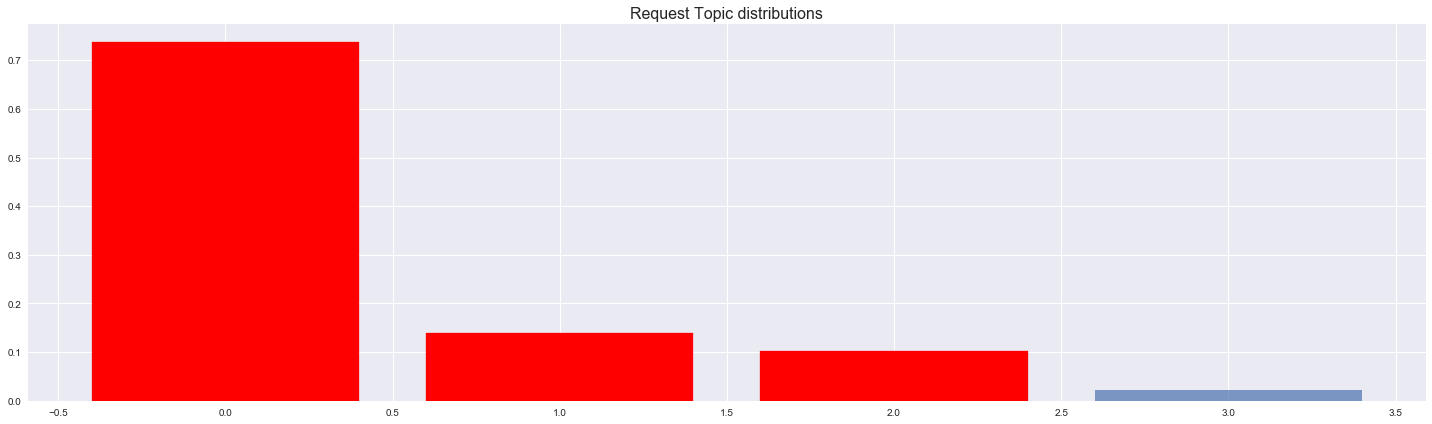

In [16]:
fig, ax1 = plt.subplots(1,1,figsize=(20,6))
nr_top_bars = 3
ax1.set_title("Request Topic distributions", fontsize=16)

for ax, distribution, color in zip([ax1], [RequestTopicDistribution], ['r']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)

fig.tight_layout(h_pad=3.)

#### Inspect topics and words

In [17]:
for x in sorted(np.argsort(RequestTopicDistribution)[-num_topics:]):
    top_words = get_topic_and_prob(LDAmodel_lang, x, num_topics) #get_topic_top_words(LDAmodel, x)
    print("Topic: {0}\tProb: {1:.3f}, Words: {2}.".format(x, RequestTopicDistribution.item(x), top_words)) #(x, ", ".join(top_words)))
print("")

Topic: 0	Prob: 0.737, Words: 0.013*"dagpeng" + 0.012*"besk" + 0.011*"dag" + 0.007*"arbejd".
Topic: 1	Prob: 0.139, Words: 0.043*"the" + 0.041*"you" + 0.018*"your" + 0.017*"and".
Topic: 2	Prob: 0.103, Words: 0.027*"timer" + 0.015*"dagpeng" + 0.010*"arbejd" + 0.009*"måned".
Topic: 3	Prob: 0.022, Words: 0.004*"medlemmet" + 0.003*"stk" + 0.002*"feriedagpeng" + 0.002*"arbejd".



In [18]:
get_lda_topics(LDAmodel_lang, num_topics,25)

,Topic # 00,Topic # 01,Topic # 02,Topic # 03
0,dagpeng,the,timer,medlemmet
1,besk,you,dagpeng,stk
2,dag,your,arbejd,feriedagpeng
3,arbejd,and,måned,arbejd
4,ledig,that,løn,dagpeng
5,kontakt,from,skat,uge
6,job,regard,arbejdet,timer
7,kass,not,udbetalt,medlem
8,spørgsmål,will,virksomh,feri
9,fået,thank,selvstændig,dage


#### Name the languages

In [19]:
lang_lda_topic_names = ['Danish','English', 'Topic 3', 'Topic 4']

In [20]:
LDAmodel_lang.print_topic(0,8)

'0.013*"dagpeng" + 0.012*"besk" + 0.011*"dag" + 0.007*"arbejd" + 0.006*"ledig" + 0.006*"kontakt" + 0.006*"job" + 0.006*"kass"'

## Test the topics on our data

In [25]:
unseen_document = 'Hej gitte arensberg. Her er de to skemaer du bad om, hhv. ak 001 og ar 232. Jeg forsøgte at sende skemaerne i mandags, man men fik oplyst på introduktionsmødet tirsdag, at aaks hjemmeside ikke fungerede søndag og mandag. venlig hilsen torben lehm.'
# unseen_document = 'hello,   writing because  would like  know more about the lønsikring (.. how much does  cost extra  month   subscribed? how can  subscribe  ?).  would like  subscribe    soon  possible. thank you very much for your help.'
# unseen_document = 'specialsag - udland - 2nd u13 document - and hopefully the last one'
bow_vector = dictionary.doc2bow(preprocess_string(unseen_document))
for index, score in sorted(LDAmodel_lang[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, LDAmodel_lang.print_topic(index, 5)))

Score: 0.9654658436775208	 Topic: 0.013*"dagpeng" + 0.012*"besk" + 0.011*"dag" + 0.007*"arbejd" + 0.006*"ledig"
Score: 0.014794488437473774	 Topic: 0.043*"the" + 0.041*"you" + 0.018*"your" + 0.017*"and" + 0.013*"that"
Score: 0.011069335043430328	 Topic: 0.027*"timer" + 0.015*"dagpeng" + 0.010*"arbejd" + 0.009*"måned" + 0.006*"løn"


In [26]:
# Test function and prediction
print(PredictTopicFromString(unseen_document, LDAmodel_lang, lang_lda_topic_names))

(0.96545726, 'Danish')


### Predict language
Per every row in the dataset

In [27]:
lda_prediction(lang_lda,LDAmodel_lang, lang_lda_topic_names)

In [28]:
lang_lda.head()

,BeskedTråd_ID,OprettetFraBrev,TrådTotalAntalBeskeder,TeamAnsvarlig,Besked_ID,Retning,SendtDato,BeskedKategori,BeskedIndhold,Org_BeskedIndhold,...,text,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,prediction,pred_probability,pred_index,pred_label
0,E1BAC568-59B6-E811-82B4-0050569118B0,0,3,Forsikring,E7BAC568-59B6-E811-82B4-0050569118B0,Udgående,2018-09-12 06:59:45,Emne,hvornår blev færdiguddannet?,Hvornår blev du færdiguddannet?,...,hvornår blev færdiguddannet?,"[hvornår, blev, færdiguddannet, ?]",[færdiguddannet],[færdiguddannet],[færdiguddannet],"[(0, 1)]","[0.6943014, 0, Danish]",0.694301,0,Danish
1,E1BAC568-59B6-E811-82B4-0050569118B0,0,3,Forsikring,6874B044-5CB6-E811-82B4-0050569118B0,Udgående,2018-09-12 07:20:05,Emne,hvornår blev færdiguddannet?,Hvornår blev du færdiguddannet?,...,hvornår blev færdiguddannet?,"[hvornår, blev, færdiguddannet, ?]",[færdiguddannet],[færdiguddannet],[færdiguddannet],"[(0, 1)]","[0.69430137, 0, Danish]",0.694301,0,Danish
2,E1BAC568-59B6-E811-82B4-0050569118B0,0,3,Forsikring,A460B937-5BB6-E811-864D-005056AD2D14,Indgående,2018-09-12 07:12:40,Emne,hvornår blev færdiguddannet?,Hvornår blev du færdiguddannet?,...,hvornår blev færdiguddannet?,"[hvornår, blev, færdiguddannet, ?]",[færdiguddannet],[færdiguddannet],[færdiguddannet],"[(0, 1)]","[0.6943004, 0, Danish]",0.694300,0,Danish
3,E15E85CB-5EB6-E811-82B4-0050569118B0,0,2,Jobmatch,D6B21804-60B6-E811-864D-005056AD2D14,Indgående,2018-09-12 07:47:02,Emne,"husk, skal til velkomstmøde, aarhus","Husk, at du skal til Velkomstmøde, Aarhus",...,"husk, skal til velkomstmøde, aarhus","[husk, skal, til, velkomstmøde, aarhus]","[husk, velkomstmøde, aarhus]","[husk, velkomstmøde, aarhus]","[husk, velkomstmød, aarhu]","[(1, 1), (2, 1), (3, 1)]","[0.846473, 0, Danish]",0.846473,0,Danish
4,E15E85CB-5EB6-E811-82B4-0050569118B0,0,2,Jobmatch,21FDCFDC-7CB6-E811-82B4-0050569118B0,Udgående,2018-09-12 11:13:28,Emne,"husk, skal til velkomstmøde, aarhus","Husk, at du skal til Velkomstmøde, Aarhus",...,"husk, skal til velkomstmøde, aarhus","[husk, skal, til, velkomstmøde, aarhus]","[husk, velkomstmøde, aarhus]","[husk, velkomstmøde, aarhus]","[husk, velkomstmød, aarhu]","[(1, 1), (2, 1), (3, 1)]","[0.84648734, 0, Danish]",0.846487,0,Danish


In [29]:
lang_lda.to_pickle('data/AKA_df_lang_with_prediction.pkl')

In [ ]:
lang_lda = pd.read_pickle('data/AKA_df_lang_with_prediction.pkl')

#### Functions for language handling

#### What is the proportion of English Requests compared to Danish Requests

In [ ]:
pd.value_counts(lang_lda['pred_label']).plot.bar()

In [ ]:
lang_proportion = PlotComparison(lang_lda, 'pred_label', 'BeskedIndhold')
lang_proportion.plot.bar(x='pred_label')

In [ ]:
# lang_stats.plot.bar(x='language')

In [ ]:
lang_lda["BeskedIndhold"]=df_clean.BeskedIndhold.apply(replace_specific_words)

In [ ]:
# df_clean['CharCount_BeskedIndhold'].plot.hist(alpha=0.5, bins=50)

In [ ]:
# Inpect the head of sentences that are english
lang_lda[lang_lda['pred_label']=='english'].head()

In [ ]:
print('No. of sentences that needs translation:',len(lang_lda[lang_lda['pred_label']=='English']))

In [ ]:
# Run all above to

# Selecting dataset to work with
In this section we will transform the incoming dataset and map it to the final wording. This will enable us to switch up incoming data sets if further data preperation has been done.

In [30]:
df_final = pd.read_pickle('data/AKA_df_lang_with_prediction.pkl')

## Feature Investigation

In [31]:
def add_features(df):
#     df['BehandlingsTidDage'] = df['BehandlingsTidTimer']/24
#     df = df.round({'BehandlingsTidDage': 0})
#     df['BehandlingsTidDage'] = df['BehandlingsTidDage'].astype(int)
#     df['CharCount_BeskedIndhold'] = df['BeskedIndhold'].apply(len)
#     df['LessThan5000'] = df['CharCount_BeskedIndhold'] < 5000
    
    df['Date'] = df['SendtDato'].dt.strftime('%Y-%m-%d')
    df['Week'] = df['SendtDato'].dt.week
    df['Year_Week'] = df['SendtDato'].dt.strftime('%Y-W%V')
    df['Weekday'] = df['SendtDato'].dt.dayofweek
    df['Month'] = df['SendtDato'].dt.month
    df['Year_Month'] = df['SendtDato'].dt.to_period('M')
    df['Year'] = df['SendtDato'].dt.year
    return df

In [32]:
df_final = add_features(df_final)

In [33]:
df_final.isnull().sum()

BeskedTråd_ID              0
OprettetFraBrev            0
TrådTotalAntalBeskeder     0
TeamAnsvarlig              0
Besked_ID                  0
Retning                    0
SendtDato                  0
BeskedKategori             0
BeskedIndhold              0
Org_BeskedIndhold          0
CharCount_BeskedIndhold    0
LessThan5000               0
text                       0
tokenized_text             0
stopwords_removed          0
lemmatized_text            0
stemmed_text               0
bow                        0
prediction                 0
pred_probability           0
pred_index                 0
pred_label                 0
Date                       0
Week                       0
Year_Week                  0
Weekday                    0
Month                      0
Year_Month                 0
Year                       0
dtype: int64

### Create copy of incoming dataset, and preform mapping

In [34]:
df_thread = df_final.copy(deep=True)
df_thread.rename(columns={
    'BeskedTråd_ID': 'ThreadID',
    'BeskedTråd_Status': 'ThreadStatus',
    'OprettetFraBrev': 'ThreadCreator',
    'TrådTotalAntalBeskeder': 'ThreadMessageCount',
    'TeamAnsvarlig': 'TeamResponsible',
    'Retning': 'ThreadDirection',
    'SendtDato': 'RequestDate',
    'BeskedKategori': 'ThreadCategory',
    'BeskedIndhold': 'RequestContent',
    'Org_BeskedIndhold': 'Orginal',
    'CharCount_BeskedIndhold': 'ReqeustContent_CharCount',
    'LessThan5000': 'Content<5000',
    'Date': 'Date',
    'Week': 'Week',
    'Weekday': 'Weekday',
    'Year_Week': 'Year_Week',
    'Month': 'Month',
    'Year_Month': 'Year_Month',
    'Year': 'Year'
    }, inplace=True)

In [35]:
list(df_thread.columns.values)

['ThreadID',
 'ThreadCreator',
 'ThreadMessageCount',
 'TeamResponsible',
 'Besked_ID',
 'ThreadDirection',
 'RequestDate',
 'ThreadCategory',
 'RequestContent',
 'Org_BeskedIndhold',
 'ReqeustContent_CharCount',
 'Content<5000',
 'text',
 'tokenized_text',
 'stopwords_removed',
 'lemmatized_text',
 'stemmed_text',
 'bow',
 'prediction',
 'pred_probability',
 'pred_index',
 'pred_label',
 'Date',
 'Week',
 'Year_Week',
 'Weekday',
 'Month',
 'Year_Month',
 'Year']

### Get stats about the dataset
This is to be used for EDA as well as data set presentation

In [36]:
df_thread.to_pickle('data/AKA_df_thread.pkl')

### Data Investigation for Outlier analysis

In [ ]:
df_thread.describe()

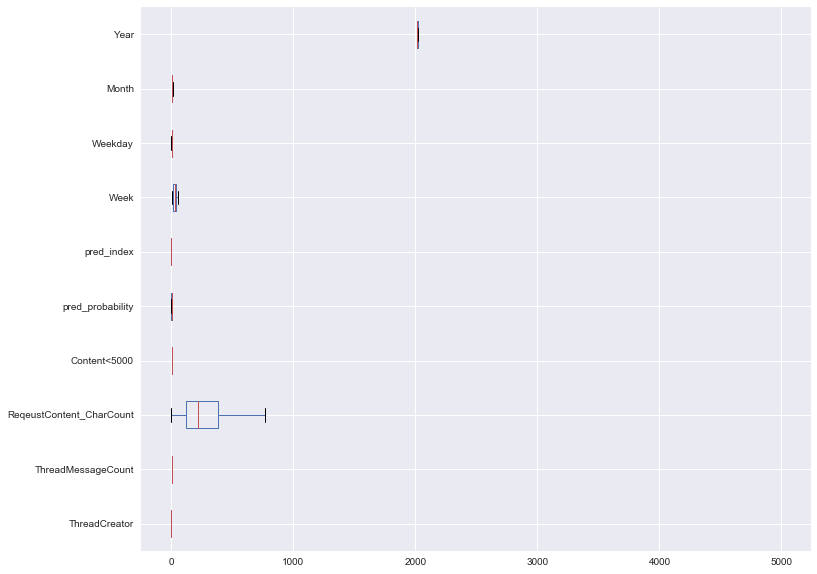

In [41]:
df_thread[df_thread['ThreadCategory'] == "Henvendelse"].boxplot(figsize=(12, 10), vert=False)

Looking at the boxplot above as well as the description table, we need to do som furhter investatation, as there are some outliers.

In [ ]:
# Looking into the MessageCount
col = 'ThreadMessageCount'
total = len(df_thread[col])
for x in range(2,20):
    no_treads = len(df_thread[df_thread[col]==x])
    pct_total = no_treads/total
    print('{1} Threads with {0} Messages, {2:.2f}% of total'.format(x, no_treads, pct_total))

In [ ]:
# Looking into the MessageCount
col = 'RequestProcessTime_Hours'
total = len(df_thread[col])
for x in range(2,20):
    no_treads = len(df_thread[df_thread[col]==x])
    pct_total = no_treads/total
    print('{1} Threads with process time {0} hours, {2:.2f}% of total'.format(x, no_treads, pct_total))

In [ ]:
# Looking into the MessageCount
col = 'RequestProcessTime_Days'
total = len(df_thread[col])
for x in range(2,20):
    no_treads = len(df_thread[df_thread[col]==x])
    pct_total = no_treads/total
    print('{1} Threads with process time {0} days, {2:.2f}% of total'.format(x, no_treads, pct_total))

In [ ]:
# Looking into the MessageCount
col = 'ReqeustContent_CharCount'
total = len(df_thread[col])
for x in range(200,601, 25):
    no_treads = len(df_thread[df_thread[col]<=x])
    pct_total = no_treads/total
    print('{1} Threads with less than {0} Characters in Request, {2:.2f}% of total'.format(x, no_treads, pct_total))

In [ ]:
%%time
def line_plot(df):
    fig, ax = plt.subplots(figsize=(18,7))
    df.groupby(['Year_Month']).sum()['RequestProcessTime_Hours'].plot(ax=ax)
line_plot(df_thread)
print(datetime.now())

In [ ]:
%%time
def line_plot(df):
    fig, ax = plt.subplots(figsize=(18,7))
    df.groupby(['Year_Month']).mean()['RequestProcessTime_Hours'].plot(ax=ax)
line_plot(df_thread)
print(datetime.now())

In [ ]:
%%time
def line_plot(df):
    fig, ax = plt.subplots(figsize=(18,7))
    df.groupby(['Year_Month']).sum()['ThreadMessageCount'].plot(ax=ax)
line_plot(df_thread)
print(datetime.now())

In [ ]:
%%time
def line_plot(df):
    fig, ax = plt.subplots(figsize=(18,7))
    df.groupby(['Year_Month']).count()['ThreadID'].plot(ax=ax)
line_plot(df_thread)
print(datetime.now())

In [ ]:
def line_plot(df):
    fig, ax = plt.subplots(figsize=(15,7))
    df.groupby(['Month']).count()['ThreadID'].plot(ax=ax, kind='bar', color='gray')
line_plot(df_thread)

In [ ]:
df_thread['RequestProcessTime_Days'].hist(color='grey', figsize=(14, 8))

In [ ]:
df_thread['Month'].hist(color='grey', figsize=(14, 8))

In [ ]:
# from pandas.plotting import scatter_matrix
# scatter_matrix(df_concat, alpha=0.2, figsize=(14, 14), diagonal='kde', color='grey')

In [ ]:
df_thread.head()

### 2.1) Split data
We split data into the three categories:
1. df_emne: This dataframe holds all subjects
2. df_first: this dataframe holds the first message from the member - this is the message that we refere to as 'henvendelse'
3. df_last: this dataframe holds the last message. This point of this data set is to assemble all messages from 'AKA' that can be used to find the 'right' answer to the first message 'henvendelsen'

In [9]:
df_thread = pd.read_pickle('data/AKA_df_thread.pkl')

In [11]:
df = df_thread.copy(deep=True)
# df = df.drop(['oversat'], axis=1)
df_subject_aka = df[(df['ThreadCategory'] == "Emne") & (df['pred_label']=='Danish') & (df['ThreadDirection']=='Udgående')]
df_subject_memb = df[(df['ThreadCategory'] == "Emne") & (df['pred_label']=='Danish') & (df['ThreadDirection']=='Indgående')]
df_outgoing = df[(df['ThreadCategory'] == "Henvendelse") & (df['pred_label']=='Danish') & (df['ThreadDirection']=='Udgående')]
df_incoming = df[(df['ThreadCategory'] == "Henvendelse") & (df['pred_label']=='Danish') & (df['ThreadDirection']=='Indgående')]
list_df = [df_subject_aka, df_outgoing, df_outgoing,df_incoming]
names_df = ['df_subject_aka', 'df_subject_memb', 'df_outgoing','df_incoming']

df_dict = dict(zip(names_df, list_df))

for k, v in df_dict.items():
    print("There are {1} rows in dataframe {0}".format(k, v.shape[0]))

There are 217193 rows in dataframe df_subject_aka
There are 230579 rows in dataframe df_subject_memb
There are 230579 rows in dataframe df_outgoing
There are 216695 rows in dataframe df_incoming


In [ ]:
PlotValueCounts(df_subject,'RequestContent',20)
df_subject['RequestContent'].value_counts()[:20,]

In [ ]:
PlotValueCounts(df_request,'ThreadCategory',10)
df_request['ThreadCategory'].value_counts()[:10,]

In [ ]:
PlotValueCounts(df_subject,'ThreadDirection',4)
df_subject['ThreadDirection'].value_counts()[:4,]

In [ ]:
df_outgoing.isnull().sum()

### Investigate data
Understand where to make a cut-off, to remove outliers that infliuences final result

In [ ]:
def column_stats(df,column, word_count):
#     def inner_map(df[column]):
#         result = []
#         for 
    try:
        document_lengths = np.array(list(map(len, df[column].str.split(' '))))
        fig, ax = plt.subplots(figsize=(15,6))
        ax.set_title("Distribution of number of words in {}".format(column), fontsize=16)
        ax.set_xlabel("Number of words")
        sns.distplot(document_lengths, bins=50, ax=ax);
        print("The total number of rows in the dataframe is {}".format(df.shape[0]))
        print("The total count of words in {} is: {}.".format(column, np.sum(document_lengths)))
        print("The average number of words in {} is: {}.".format(column, np.mean(document_lengths)))
        print("The minimum number of words in {} is: {}.".format(column, min(document_lengths)))
        print("The maximum number of words in {} is: {}.".format(column, max(document_lengths)))
        print("There are {} requests in {} with over {} words.".format(sum(document_lengths > word_count), column, word_count))
        print("There are {} requests in {} with tops 5 words.".format(sum(document_lengths <= 5), column))
        return document_lengths
    except TypeError as e:
        print(e, )

In [ ]:
doc_subject_memb = column_stats(df_subject_memb, 'RequestContent', 20)

In [ ]:
df_subject_memb = df_subject[doc_subject_memb < 20] # Cutting of at 20
doc_subject_memb = column_stats(df_subject_memb, 'RequestContent', 15)

In [ ]:
doc_outgoing = column_stats(df_outgoing, 'RequestContent', 250)

In [ ]:
df_outgoing = df_outgoing[doc_outgoing < 300] # Cutting of at 500
doc_outgoing = column_stats(df_outgoing, 'RequestContent', 200)

In [ ]:
doc_request = column_stats(df_request, 'RequestContent', 500)

In [ ]:
# document_lengths = np.array(list(map(len, df_henvendelse['BeskedIndhold_danish'].str.split(' '))))
# df_henvendelse['BeskedIndhold_danish'].str.split(' ')

In [ ]:
df_request = df_request[doc_request < 500] # Cutting of at 500
doc_request = column_stats(df_request, 'RequestContent', 400)
# df[doc_BT <= 6]

In [44]:
df_outgoing.shape

(230579, 29)

In [12]:
# Save the data sets
df_subject_memb.to_pickle('data/AKA_df_subject_memb.pkl')
df_subject_aka.to_pickle('data/AKA_df_subject_aka.pkl')
df_outgoing.to_pickle('data/AKA_df_outgoing.pkl')
df_incoming.to_pickle('data/AKA_df_incoming.pkl')

## Analyze Requests
Messages are either
- Incoming (from members) or
- Outgoing (from aka)
All messeages have
- subject_field and
- message_field

In the following we will analyze the different splits of data, with regards to the above:
- Incoming_subject
- Incoming_message
- Outgoing_subject
- Outgoing_message

### Request Analysis: subject_member

In [40]:
# Load the data, and print rows, columns
df_subject_memb = pd.read_pickle('data/df_B.pkl')
df_subject_memb.shape

(161867, 23)

### 2.2) Tokenize the text

In [42]:
analysis_df = df_subject_memb.copy(deep=True)

In [43]:
def word_frequency(text_list, num_list, sep=None):
    """
    abs_freq : absolute frequency of the words
    abs_perc : 
    abs_perc_cum : cumulative percenatages of each type of frequency
    """
    from collections import defaultdict
    word_freq = defaultdict(lambda: [0, 0])
    try:
        for text, num in zip(text_list, num_list):
            for word in text.split(sep=sep): 
                word_freq[word][0] += 1 
    except AttributeError as e:
        print(e, word, text, num)

    columns = {0: 'abs_freq'}

    abs_wtd_df = (pd.DataFrame.from_dict(word_freq, orient='index')
                 .rename(columns=columns )
                 .sort_values('abs_freq', ascending=False)
#                  .assign(rel_value=lambda df: df['wtd_freq'] / df['abs_freq']).round()
                 )

    abs_wtd_df.insert(1, 'abs_perc', value=abs_wtd_df['abs_freq'] / abs_wtd_df['abs_freq'].sum())
    abs_wtd_df.insert(2, 'abs_perc_cum', abs_wtd_df['abs_perc'].cumsum())
    
#     abs_wtd_df['word'] = abs_wtd_df.index
    abs_wtd_df = abs_wtd_df.reset_index()#level=0, inplace=True)
    abs_wtd_df = abs_wtd_df.rename(columns = {'index':'word'})
    abs_wtd_df.drop([1], axis=1)

    return abs_wtd_df

In [45]:
df_wrd_feq = word_frequency(analysis_df['ThreadMessageText'], analysis_df['ThreadSubject'])
df_wrd_feq.head(30)

,word,abs_freq,abs_perc,abs_perc_cum,1
0,jeg,583411,0.070167,0.070167,0
1,har,217687,0.026181,0.096349,0
2,til,158716,0.019089,0.115438,0
3,for,138179,0.016619,0.132057,0
4,det,135153,0.016255,0.148311,0
5,.,119196,0.014336,0.162647,0
6,ikke,117447,0.014125,0.176773,0
7,med,105119,0.012643,0.189415,0
8,den,103090,0.012399,0.201814,0
9,min,90532,0.010888,0.212703,0


In [46]:
selected_column = 'tokenized_text' # 'stopwords_removed' # 
tokenized_only_dict = Counter(np.concatenate(analysis_df[selected_column].values))
tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [47]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

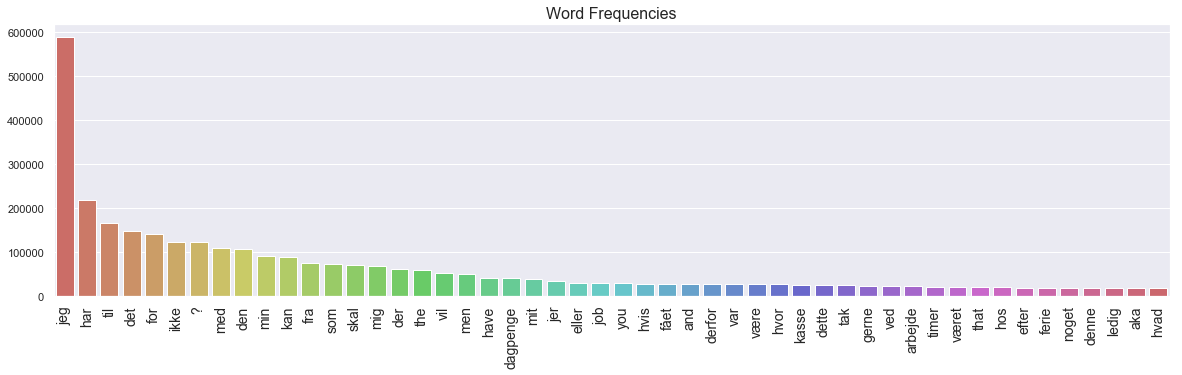

In [48]:
# I made a function out of this since I will use it again later on 
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);

### 2.3) Remove words that mean little
As stated above, words the have little meaning to the model are words we'd like to remove. Moreover, these words can create noise which can make it harder to classify the texts later on.

In [54]:
# remove_stopwords(analysis_df)

### 2.4) Stemming
For the stemming part, we'll start with lemmatization, this will stem words like leaves to leaf. Afterwards, we'll apply the porterstemmer which in turn will complete the stemming by converting words like running to run.

In [55]:
# stem_words(analysis_df)

In [49]:
print((analysis_df.columns.values))
# analytics['text','stopwords_removed',]

['ThreadID' 'ThreadCreatedFromLetter' 'ThreadTotalMessageCount'
 'ThreadStatus' 'ThreadSubject' 'ThreadResponsibleDepartment'
 'ThreadResponsibleDepartmentTeam' 'ThreadHasInteraction'
 'ThreadInitiatedBy' 'ThreadMessageRank'
 'ThreadMessageIsFirstMemberMessage' 'ThreadMessageIsFirstAKAMessage'
 'ThreadMessageID' 'ThreadMessageDirection' 'ThreadMessageDateCreated'
 'ThreadMessageText' 'CharCount_ThreadMessageText' 'LessThan5000' 'text'
 'tokenized_text' 'stopwords_removed' 'lemmatized_text' 'stemmed_text']


### 2.5) Vectorize words
Here we create a dictionary for the model. Since a computer can't reallly understand what a word means, we need to transform it into some number the model will be able to work with. We use gensim.corpora.Dictionary for this.

In [50]:
dictionary = Dictionary(documents=analysis_df.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 124632 words.


#### Parameters:	
- **no_below** (int, optional) – Keep tokens which are contained in at least no_below documents.
- **no_above** (float, optional) – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
- **keep_n** (int, optional) – Keep only the first keep_n most frequent tokens.
- **keep_tokens** (iterable of str) – Iterable of tokens that must stay in dictionary after filtering.

In [51]:
# dictionary.filter_extremes(no_above=0.8, no_below=3)
dictionary.filter_extremes(keep_n=500)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 500 words.


In [52]:
top_words = [v for v in dictionary.values()]

In [53]:
print("Left with {} words.".format(len(top_words)))

Left with 500 words.


In [54]:
#Make a BoW for every Besked
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(analysis_df)

In [55]:
#Make a dictionary_stem_text for every Besked
# def document_to_bow(df):
#     df['dictionary_stem_text'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
# document_to_bow(analysis_df)

In [56]:
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

### Visualize the cleansed words frequencies
Excellent! We cleansed our data and are ready to continue with LDA Analysis and Word2Vec, but before we do that, I would like to visualize the cleansed results and see what we created so far.

In [57]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

In [58]:
cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [59]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

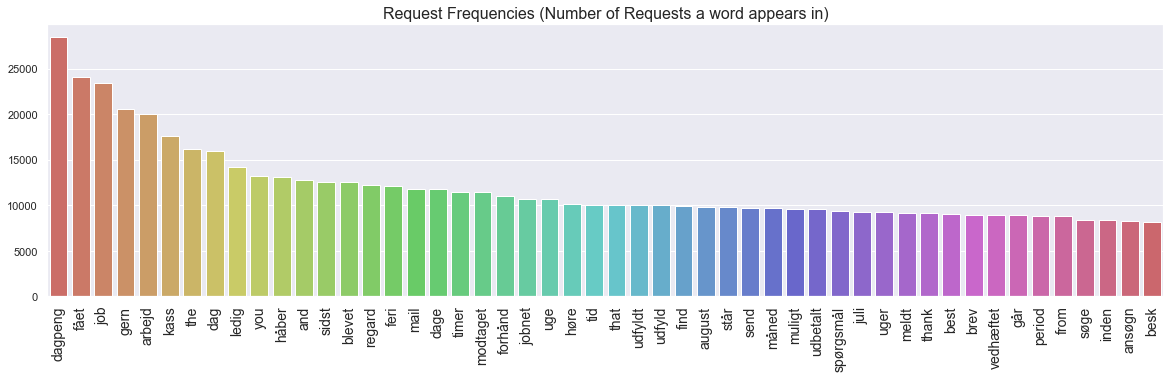

In [60]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Request Frequencies (Number of Requests a word appears in)", fontsize=16);

In [61]:
cleansed_words_df.to_excel('data/AKA_top500.xlsx')

ModuleNotFoundError: No module named 'openpyxl'

## Find Optimal number of topics for LDA

#### K-means Elbow method

In [62]:
from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [63]:
sample_size=5000

In [64]:
df_elbow = analysis_df.sample(sample_size, random_state=1)

In [65]:
# df_elbow.to_pickle('data/AKA_df_elbow.pkl')

In [66]:
# df_elbow = pd.read_pickle('data/AKA_df_subject_memb.pkl')

In [67]:
list(df_elbow.columns.values)

['ThreadID',
 'ThreadCreatedFromLetter',
 'ThreadTotalMessageCount',
 'ThreadStatus',
 'ThreadSubject',
 'ThreadResponsibleDepartment',
 'ThreadResponsibleDepartmentTeam',
 'ThreadHasInteraction',
 'ThreadInitiatedBy',
 'ThreadMessageRank',
 'ThreadMessageIsFirstMemberMessage',
 'ThreadMessageIsFirstAKAMessage',
 'ThreadMessageID',
 'ThreadMessageDirection',
 'ThreadMessageDateCreated',
 'ThreadMessageText',
 'CharCount_ThreadMessageText',
 'LessThan5000',
 'text',
 'tokenized_text',
 'stopwords_removed',
 'lemmatized_text',
 'stemmed_text',
 'bow']

In [68]:
df_elbow.head()

,ThreadID,ThreadCreatedFromLetter,ThreadTotalMessageCount,ThreadStatus,ThreadSubject,ThreadResponsibleDepartment,ThreadResponsibleDepartmentTeam,ThreadHasInteraction,ThreadInitiatedBy,ThreadMessageRank,...,ThreadMessageDateCreated,ThreadMessageText,CharCount_ThreadMessageText,LessThan5000,text,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow
725075,29E6C0AA-7789-E611-B263-005056AD2D14,0,2,Fuldført,Status som ledig?,Forsikring,Udbetalingsteam 1 - CPR 01 til 10,1,Member,1,...,2016-10-03 14:42:59,"ved fejl kom jeg til stå som ledig jobnet., hv...",322,True,"ved fejl kom jeg til stå som ledig jobnet., hv...","[ved, fejl, kom, jeg, til, stå, som, ledig, jo...","[fejl, stå, ledig, jobnet, stod, sende, ledigh...","[fejl, stå, ledig, jobnet, stod, sende, ledigh...","[fejl, stå, ledig, jobnet, stod, send, ledighe...","[(10, 5), (13, 1), (33, 2), (35, 1), (47, 2), ..."
334947,D7BFA427-EFDF-E711-8CAD-005056AD2D14,0,2,Fuldført,Uddannelse,Forsikring,Medlemskabsteam,1,Member,1,...,2017-12-13 10:20:02,"hej, jeg kommet ind kandidat som starter febru...",169,True,"hej, jeg kommet ind kandidat som starter febru...","[hej, jeg, kommet, ind, kandidat, som, starter...","[kommet, kandidat, starter, februar, ringede, ...","[kommet, kandidat, starter, februar, ringede, ...","[kommet, kandidat, starter, februar, ringed, g...","[(22, 1), (41, 1), (158, 1), (179, 1), (293, 1..."
531039,57850659-F6FD-E611-AC9F-005056AD2D14,0,2,Fuldført,nyt skattekort gældende fra 26.2,Forsikring,Udbetalingsteam 2 - CPR 11 til 20,1,Member,1,...,2017-02-28 20:42:07,"jeg har fået nyt skattekort gældende fra .., h...",134,True,"jeg har fået nyt skattekort gældende fra .., h...","[jeg, har, fået, nyt, skattekort, gældende, fr...","[fået, skattekort, gældende, håber, bruges, be...","[fået, skattekort, gældende, håber, bruges, be...","[fået, skattekort, gældend, håber, bruge, beta...","[(11, 1), (28, 1), (39, 1), (91, 1), (160, 1),..."
27722,932D6A22-6623-E611-8BE5-0050569118B0,1,2,Fuldført,Du kan få supplerende dagpenge med arbejde på ...,Forsikring,Udbetalingsteam 1 - CPR 01 til 10,1,Member,1,...,2016-05-26 17:20:31,"måske dette bare automatisk mail, men jeg har ...",59,True,"måske dette bare automatisk mail, men jeg har ...","[måske, dette, bare, automatisk, mail, men, je...","[automatisk, mail, fået, arbejde]","[automatisk, mail, fået, arbejde]","[automatisk, mail, fået, arbejd]","[(28, 1), (29, 1), (164, 1), (446, 1)]"
844330,BFCAE8E4-15A3-E711-B45B-005056AD2D14,0,3,Fuldført,att. medlemsskabsafdeling - nyuddannet,Forsikring,Medlemskabsteam,1,Member,1,...,2017-09-26 23:53:38,". / / 2017 fik jeg vide jer over telefonen, ...",978,True,". / / 2017 fik jeg vide jer over telefonen, ...","[fik, jeg, vide, jer, over, telefonen, selvom,...","[vide, telefonen, nået, melde, indenfor, uger,...","[vide, telefonen, nået, melde, indenfor, uger,...","[vide, telefonen, nået, meld, indenfor, uger, ...","[(13, 1), (16, 1), (20, 1), (54, 1), (66, 3), ..."


In [62]:
df_elbow[['ThreadID','RequestContent','Org_BeskedIndhold','text','tokenized_text','stopwords_removed','lemmatized_text','stemmed_text']].head()

,ThreadID,RequestContent,Org_BeskedIndhold,text,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text
370494,2AED74C0-B8BC-E611-B361-005056AD2D14,velkommen akademikernes -kasse som nyuddannet,Velkommen i Akademikernes A-kasse som nyuddannet,velkommen akademikernes -kasse som nyuddannet,"[velkommen, akademikernes, kasse, som, nyuddan...","[velkommen, kasse, nyuddannet]","[velkommen, kasse, nyuddannet]","[velkommen, kass, nyuddannet]"
30274,DA6F564D-D86D-E611-8BE5-0050569118B0,adresse,Ny adresse,adresse,[adresse],[adresse],[adresse],[adress]
402863,5D9E57CC-8A62-E811-B843-005056AD2D14,att. pia andersen,Att. Pia Andersen,att. pia andersen,"[att, pia, andersen]","[att, pia, andersen]","[att, pia, andersen]","[att, pia, andersen]"
541472,F791ACBF-FF45-E711-BE8E-005056AD2D14,vedhæftelse ak001,Vedhæftelse af AK001,vedhæftelse ak001,"[vedhæftelse, ak001]","[vedhæftelse, ak001]","[vedhæftelse, ak001]","[vedhæftels, ak001]"
96984,08024E8C-34AC-E811-B398-0050569118B0,afholdelse ferie,Afholdelse af ferie,afholdelse ferie,"[afholdelse, ferie]","[afholdelse, ferie]","[afholdelse, ferie]","[afholdels, feri]"


In [63]:
# df_import['Besked_Tekst'][df_import['BeskedTråd_ID']=='ABB7AE21-2128-E711-AC9F-005056AD2D14']

In [71]:
def ListToString(df):
    return ', '.join(df)

def AddTopWordFeatures(df, text_col , top_word_list):
    """ Creates
            - topwords_count: a count of top words found in 'text_col'
            - topwords_found: a bool indication of any top words found in 'text_col'
            - a new column per word i 'top_word_list' with True / False if the word in 'top_word_list' is found in 'text_col'
        There is no output, as all is DataFrame operations, that happen to the input 'df'
        """
    df['topwords_count'] = df[text_col].apply(lambda x: sum(i in top_word_list for i in x.split()))
    df['topwords_found'] = df[text_col].apply(lambda x: any(i in top_word_list for i in x.split()))
    
    # Create a new column per word in 'top_word_list'
    pd.concat([df, pd.DataFrame(columns = list(top_word_list))], sort=False)
    
    # Fills the newly created columns with a bool value if the word was found in the 'text_col'
    for c in top_word_list:
        df[c] = df[text_col].apply(lambda x: c in x.split())
        
def remove_not_topwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    Parameters:
    - no_below (int, optional) – Keep tokens which are contained in at least no_below documents.
    - no_above (float, optional) – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
    - keep_n (int, optional) – Keep only the first keep_n most frequent tokens.
    - keep_tokens (iterable of str) – Iterable of tokens that must stay in dictionary after filtering
    """
    dictionary = Dictionary(documents=analysis_df.stemmed_text.values) # analysis_df
    
    # dictionary.filter_extremes(no_above=0.8, no_below=3, keep_n=500, keep_tokens=None)
    dictionary.filter_extremes(keep_n=500)

    dictionary.compactify()
    
    top_words = [v for v in dictionary.values()]

    top_words = list(set(top_words))

    df['OnlyTopWords'] = list(map(lambda doc:
                                       [word for word in doc if word in top_words],
                                       df['stemmed_text']))
    return top_words

In [72]:
%%time
top_words = remove_not_topwords(df_elbow)

Wall time: 6.89 s


In [73]:
print("Left with {} words.".format(len(top_words)))

Left with 500 words.


In [74]:
%%time
df_elbow['clean_content'] = df_elbow['OnlyTopWords'].apply(ListToString)

Wall time: 8 ms


In [75]:
text_clean = []
for text in df_elbow['clean_content']:
    text_clean.append(text.split())

#### Tf-idf and document similarity

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the clean_content list into a tf-idf matrix.

To get a Tf-idf matrix, first count word occurrences by request. This is transformed into a request-term matrix (dtm). This is also just called a term frequency matrix.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a request but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the request.

A couple things to note about the parameters I define below:

max_df: this is the maximum frequency within the request a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the request it probably cares little meanining - rule of thumb (verify this)

min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the request to be considered. Here I pass 0.2; the term must be in at least 20% of the request. 

TEST THIS
I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.

ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See n-grams

In [68]:
%%time
tfidf_wordvector = TfidfVectorizer(
                analyzer='word', 
                max_df=0.8, 
                min_df=5, 
#                 stop_words=stopwords.words('danish'),
#                 ngram_range=(1,3)
                ) 

tfidf_wordvector_maxtrix = tfidf_wordvector.fit_transform(df_elbow.clean_content) #fit the tfidf_wordvector to clean_content

print(tfidf_wordvector_maxtrix.shape)

(5000, 358)
Wall time: 33 ms


terms is just a list of the features used in the tf-idf matrix. This is a vocabulary

In [69]:
terms = tfidf_wordvector.get_feature_names()

In [70]:
print('No. of words in tf-idf matrix: {}'.format(len(terms)))

No. of words in tf-idf matrix: 358


dist is defined as 1 - the cosine similarity of each request. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each request and the other request in the corpus (each clean_content among the total clean_content). Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.

Note that with dist it is possible to evaluate the similarity of any two or more clean_content.

In [71]:
from sklearn.metrics.pairwise import cosine_similarity

In [88]:
# dist = 1 - cosine_similarity(tfidf_wordvector_maxtrix)

In [73]:
labels = tfidf_wordvector.vocabulary_#.values

In [74]:
tfidf_wordvector_2d = tfidf_wordvector_maxtrix.todense()

In [75]:
len(tfidf_wordvector_2d)

5000

In [89]:
X = tfidf_wordvector_2d
distortions = []
top_range = 151
increments = 5
n_inc = round(top_range/increments)

In [90]:
%%time
K = range(1,top_range,increments)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_jobs=-1, random_state=0).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

Wall time: 4min 59s


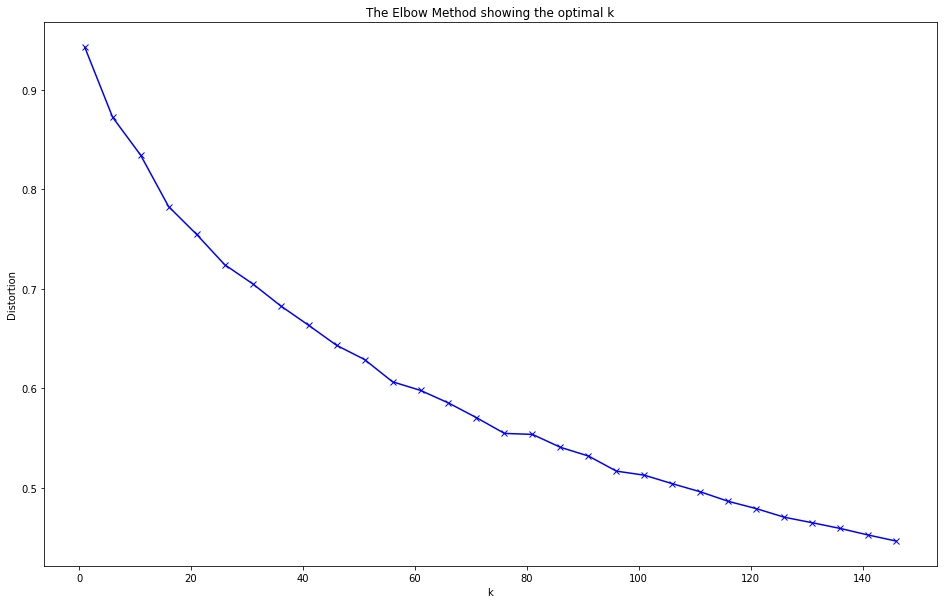

In [91]:
# Plot the elbow
plt.figure(figsize=(16, 10))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')#, Using Sample Size: {}, Top {} Words, with increments of {} from 0 to {}'.format(sample_size, len(terms), n_inc, top_range-1))
plt.show()

In [79]:
%%time
# Plot optimal no of clusters from elbow above
num_clusters = 70
kmeans = KMeans(n_clusters=num_clusters, n_jobs=-1, random_state=0)

# # Convert numpy matrix to 1-d array for k-means
# tfidf_wordvector_1d = np.squeeze(np.asarray(tfidf_wordvector_2d))

# # Compute cluster centers and predict cluster indices
# X_clustered = kmeans.fit_predict(tfidf_wordvector_1d)

%time
kmeans.fit(tfidf_wordvector_maxtrix)

Wall time: 0 ns
Wall time: 2.81 s


In [94]:
clusters = kmeans.labels_.tolist()

In [ ]:
# Plot the scatter digram
# plt.figure(figsize = (6,6))
# plt.scatter(tfidf_wordvector_1d[:,0],tfidf_wordvector_1d[:,1], alpha=0.5) 
# plt.show()

### Get top words from requests
We create a function that takes a single row of the tf-idf matrix (corresponding to a particular document), and return the n highest scoring words (or more generally tokens or features):

In [ ]:
from sklearn.decomposition import PCA
plt.figure(figsize=(16, 10))
coords = PCA(n_components=2).fit_transform(tfidf_wordvector_2d)
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

In [ ]:
def top_tfidf_feats(row, features, top_n=25):
    """ Get top n tfidf values in row and return them with their corresponding feature names. """ 
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

Here we use argsort to produce the indices that would order the row by tf-idf value, reverse them (into descending order), and select the first top_n. We then return a pandas DataFrame with the words themselves (feature names) and their corresponding score.

The result of a tf-idf, however, is typically a sparse matrix, which doesn’t support all the usual matrix or array operations. So in order to apply the above function to inspect a particular document, we convert a single row into dense format first:

In [ ]:
def top_feats_in_doc(X, features, row_id, top_n=25):
    """ Top tfidf features in specific document (matrix row) """
    row = np.squeeze(np.asarray(X[row_id]))
    return top_tfidf_feats(row, features, top_n)

Using this to show the top 20 words used in the second document of our matrix, for example:

In [ ]:
features = tfidf_wordvector.get_feature_names() # Same as terms above
print(top_feats_in_doc(tfidf_wordvector_2d, features, 0, 20))

 Let’s see if this topic is represented also in the overall corpus. For this, we will calculate the average tf-idf score of all words across a number of documents (in this case all documents), i.e. the average per column of a tf-idf matrix:

In [ ]:
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.10, top_n=25):
    """ Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids """
    if grp_ids:
        D = np.asarray(X[grp_ids])
    else:
        D = np.asarray(X)
        
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    
    return top_tfidf_feats(tfidf_means, features, top_n)

Here, we provide a list of row indices which pick out the particular documents we want to inspect. Providing ‘None’ indicates, somewhat counterintuitively, that we’re interested in all documents. We then calculate the mean of each column across the selected rows, which results in a single row of tf-idf values. And this row we then simply pass on to our previous function for picking out the top n words. One crucial trick here, however, is to first filter out the words with relatively low scores (smaller than the provided threshold). This is because common words, such as ‘a’ or ‘the’, while having low tf-idf scores within each document, are so frequent that when averaged over all documents they would otherwise easily dominate all other terms.

Calling this function with grp_ids=None, gives us the most important words across the whole corpus. Here are the top 20:

In [ ]:
top_mean = top_mean_feats(tfidf_wordvector_2d, features, top_n=10)
top_mean

In [ ]:
def top_feats_by_class(X, y, features, min_tfidf=0.1, top_n=10):
    """Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. """
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

This function uses the previously defined functions to return a list of DataFrames, one per document class, and each containing the top n features. Instead of printing them out as a table, we will visualize them using the following fuction:

In [ ]:
def plot_tfidf_classfeats_h(dfs):
    """Plot the data frames returned by the function plot_tfidf_classfeats(). """
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [ ]:
list_dfs = top_feats_by_class(tfidf_wordvector_2d, top_mean.features ,features)

In [ ]:
plot_tfidf_classfeats_h(list_dfs)

What might be more interesting, though, is to separately consider groups of documents falling into a particular category. For example, let’s calculate the mean tf-idf scores depending on a document’s class label:

## LDA Model Training
Latent Dirichlet Allocation (LDA) is generative approach in classifying texts. It is a three level hierarchical Bayesian model where it creates probabilities on word level, on document level and on corpus level (corpus means all documents)

We want to maximize the probability of the corpus in the training set.



In [76]:
corpus = analysis_df.bow

In [77]:
%%time
num_topics = 20
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=10000,
                        passes=50,
                        alpha='asymmetric')

KeyboardInterrupt: 

### LDA topic inspection
Let's first create the feature vectors.

In [78]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

analysis_df['lda_features'] = list(map(lambda doc: document_to_lda_features(LDAmodel, doc), analysis_df.bow))

NameError: name 'LDAmodel' is not defined

Now let's continue with the topic distributions and let's see some words that come with the topics

In [95]:
RequestTopicDistribution = analysis_df['lda_features'].mean()

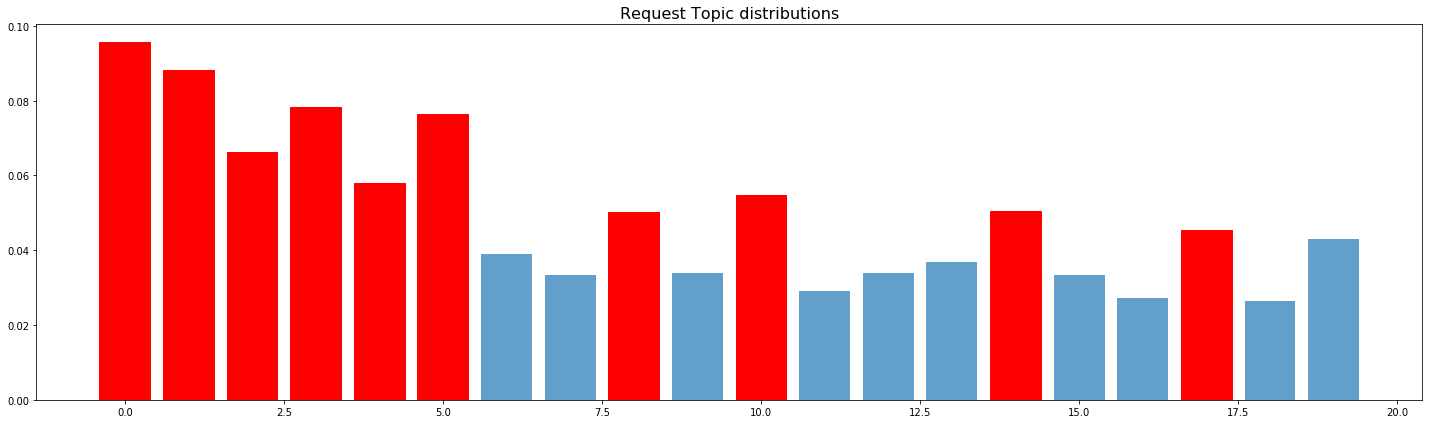

In [96]:
fig, ax1 = plt.subplots(1,1,figsize=(20,6))
nr_top_bars = 10
ax1.set_title("Request Topic distributions", fontsize=16)
# ax1.text(-15, 0.045, "Average Probability of Topic", fontsize=16, ha="center", va="center", rotation="vertical")

for ax, distribution, color in zip([ax1], [RequestTopicDistribution], ['r']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
#     ax.set_xlim(-1, 150)
#     ax.set_xticks(range(20,149,20))
#     ax.set_xticklabels(range(20,149,20), fontsize=16)

fig.tight_layout(h_pad=3.)

For the sake of classification, it's good to see the top topics. Let's have a look at what words these top topics contain

In [97]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=7):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

def get_topics_and_prob(lda_model, topic_id, nr_top_words=7):
    id_tuples = lda_model.print_topics(-1)
    topic_ids = np.array(id_tuples)[:,0]
    word_tuples = np.array(id_tuples)[:,1]
    top = dict(zip(topic_ids[:nr_top_words],word_tuples[:nr_top_words]))
#     topic_prop = map(lambda x: word_tuples, topic_ids) #map(lambda id_: lda_model.id2word[id_], topic_ids)
    return top

def get_topic_and_prob(lda_model, topic_id, nr_top_words=7):
    id_tuples = lda_model.print_topic(topic_id, topn=nr_top_words)
    return id_tuples

def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in sorted(np.argsort(RequestTopicDistribution)[-num_topics:]):
        words = model.show_topic(i, topn = 10);
        word_dict['Topic # ' + '{:02d}'.format(i)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

In [98]:
for x in sorted(np.argsort(RequestTopicDistribution)[-52:]):
    top_words = get_topic_and_prob(LDAmodel, x, 5) #get_topic_top_words(LDAmodel, x)
    print("Topic: {0}\tProb: {1:.3f}, Words: {2}.".format(x, RequestTopicDistribution.item(x), top_words)) #(x, ", ".join(top_words)))
print("")

Topic: 0	Prob: 0.096, Words: 0.244*"kass" + 0.152*"konting" + 0.151*"book" + 0.077*"plad" + 0.053*"indmeldels".
Topic: 1	Prob: 0.088, Words: 0.167*"karrieresamtal" + 0.153*"husk" + 0.112*"velkomstmød" + 0.095*"velkomstsamtal" + 0.082*"udmeldels".
Topic: 2	Prob: 0.066, Words: 0.170*"angåend" + 0.088*"feriepeng" + 0.085*"medlem" + 0.059*"medlemsskab" + 0.048*"kass".
Topic: 3	Prob: 0.078, Words: 0.135*"feri" + 0.101*"kass" + 0.101*"velkommen" + 0.080*"frigørelsesattest" + 0.061*"opsigels".
Topic: 4	Prob: 0.058, Words: 0.274*"feriedagpeng" + 0.115*"specialsag" + 0.070*"efterlønsbevi" + 0.064*"selvstændigt" + 0.062*"hovederhverv".
Topic: 5	Prob: 0.077, Words: 0.360*"ansøgn" + 0.257*"dagpeng" + 0.184*"supplerend" + 0.045*"afslag" + 0.028*"ferielukn".
Topic: 6	Prob: 0.039, Words: 0.291*"spørgsmål" + 0.126*"søge" + 0.112*"feriedagpeng" + 0.060*"att" + 0.047*"studiemedlem".
Topic: 7	Prob: 0.033, Words: 0.258*"ledighedserklær" + 0.101*"ansættelseskontrakt" + 0.080*"uge" + 0.067*"attest" + 0.065*

In [99]:
get_lda_topics(LDAmodel, 52)

,Topic # 00,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19
0,kass,karrieresamtal,angåend,feri,feriedagpeng,ansøgn,spørgsmål,ledighedserklær,efterløn,møde,job,manglend,oplysning,arbejd,dagpeng,jobnet,adress,vedrørend,ledig,brev
1,konting,husk,feriepeng,kass,specialsag,dagpeng,søge,ansættelseskontrakt,barsel,samtal,dokument,oplysning,giv,udlandet,udbet,mangler,fået,ydelseskort,tid,medlemskab
2,book,velkomstmød,medlem,velkommen,efterlønsbevi,supplerend,feriedagpeng,uge,send,fejludbet,virksomhedspraktik,joblog,bliv,betal,ansøgn,oplysning,situat,fejl,nedsat,uddannels
3,plad,velkomstsamtal,medlemsskab,frigørelsesattest,selvstændigt,afslag,att,attest,redegørels,undersøg,studerend,send,dagpeng,blanket,oplysning,godkendt,vejledn,afmeld,arbejd,nyuddannet
4,indmeldels,udmeldels,kass,opsigels,hovederhverv,ferielukn,studiemedlem,godkendels,mødte,sket,ak001,jobloggen,jobsøgningen,forbindels,mangler,tilmeldt,danmark,jobcent,sidst,skift
5,arrang,booket,slettet,befordringsgodtgørels,snart,befordringsgodtgørels,karantæn,indsendt,samtal,klage,udfyld,opdat,jobsøgn,period,behandl,arrangementet,udenlandsk,regn,hjælp,endt
6,karrieresamtal,svar,erklær,samtal,ændring,kollektiv,dagpengesat,deltid,tilbud,kursu,jobsamtal,uddannels,aak,kontig,indbet,statu,aktiv,samtal,barselsdagpeng,dage
7,tilmeldt,mangler,efterlønsbidrag,velkomstmød,efterløn,feedback,ferieåret,samt,udbet,udbetalingsspecifik,juni,ifm,mødte,konting,syg,københavn,sverig,mail,maj,dato
8,problem,studiemedlemskab,forlængels,kontrakt,udland,material,tilbagebet,indsend,pension,opkrævn,juli,brug,syg,kopi,phd,kontingentfritagels,dagpengekort,ang,uger,ret
9,haster,peng,ledigh,forkert,udbetalt,bede,info,frigørelsesattest,tilmeld,jobcentret,løntilskud,afslutningsdato,anmodn,send,august,husk,arbejd,april,vejledn,studi


#### How to interpret the result
Topic: 0 is represented as: 0.053*"frigørelsesattest" + 0.049*"kontrakt" + 0.041*"vedhæftet" + 0.031*"ansættelseskontrakt" + 0.024*"fremsend" + 0.022*"kopi" + 0.021*"underskrevet" + 0.020*"sender" + 0.018*"dagpeng" + 0.017*"supplerend".
It means the top 10 words that contribute to this topic is: 'frigørelsesattest', 'kontrakt', 'vedhæftet', 'ansættelseskontrakt' and so on and the weight of 'frigørelsesattest' on topic 0 is 0.053.

The weight is a reflection on how important a keywords is to that topic. Looking at the 10 ten words for topic 0, we could topic 0 as 'Kontrakt' or 'Kontrakt assistance'

The exercise is to look at the words for each topic, and then summarize the topic with a common defining term.

### Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is.

In [ ]:
# analysis_df.dtypes
analysis_df.isnull().sum()

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', LDAmodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

In [ ]:
# Compute Coherence Score using UMass Measure
coherence_model_lda = CoherenceModel(model=LDAmodel, corpus=corpus, texts=analysis_df['lemmatized_text'], dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Compute Coherence Score using u_mass Measure
coherence_model_lda = CoherenceModel(model=LDAmodel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Compute Coherence Score using c_v Measure
coherence_model_lda = CoherenceModel(model=LDAmodel, texts=analysis_df['lemmatized_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)